In [61]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from concurrent.futures import ThreadPoolExecutor



In [62]:
# This project is to analyze the churn data of a service provider and hopefully create a prediction model so they can lower customer churn.
# First, lets start with gathering the data and cleaning it.

In [63]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [64]:
data = pd.read_csv(path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [65]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [66]:
data.duplicated().sum()

np.int64(0)

In [67]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [68]:
data = data.drop("customerID", axis = 1)

In [69]:
data[data['TotalCharges'] == '']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [70]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors = 'coerce')

In [71]:
data['TotalCharges'] = data['TotalCharges'].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset = ['TotalCharges'])

In [72]:
data.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [73]:
print(data.select_dtypes(exclude = ['number']).columns)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')


In [74]:
#This function was originally running slow so I had to implement parallel processing
from concurrent.futures.thread import ThreadPoolExecutor
def process_cols(data):
  for col in data.select_dtypes(include = 'number').columns:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    IQR = q3 - q1
    outliers = data[(data[col] < (q1 - 1.5 * IQR)) | (data[col] > (q3 + 1.5 * IQR))]
    if len(outliers) > 0:
      print(f"{col} - Outliers: {len(outliers)}")
      print(outliers[[col]])
      print("====================================")

def outliers(data):
  numeric_cols = data.select_dtypes(include = ['number']).columns
  with ThreadPoolExecutor() as executor:
    executor.map(process_cols, data[numeric_cols])

In [75]:
outliers(data)

In [76]:
data[data["tenure"] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [77]:
data.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [78]:
# Now that we cleaned the data, we can begin graphing different variables to understand the relationships better

In [79]:
def plot_dist(data):
  numeric_cols = data.select_dtypes(include = ['number']).columns

  num_cols = len(numeric_cols)
  num_rows = (num_cols // 3) + 1

  plt.figure(figsize = (12, 4 * num_rows))

  for i, col in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(data[col], kde = True, color = 'blue', bins = 30)
    plt.title(f'Distribution of {col}', fontsize = 10)
    plt.xlabel(col)
    plt.ylabel('Frequency')

  plt.tight_layout()
  plt.show()

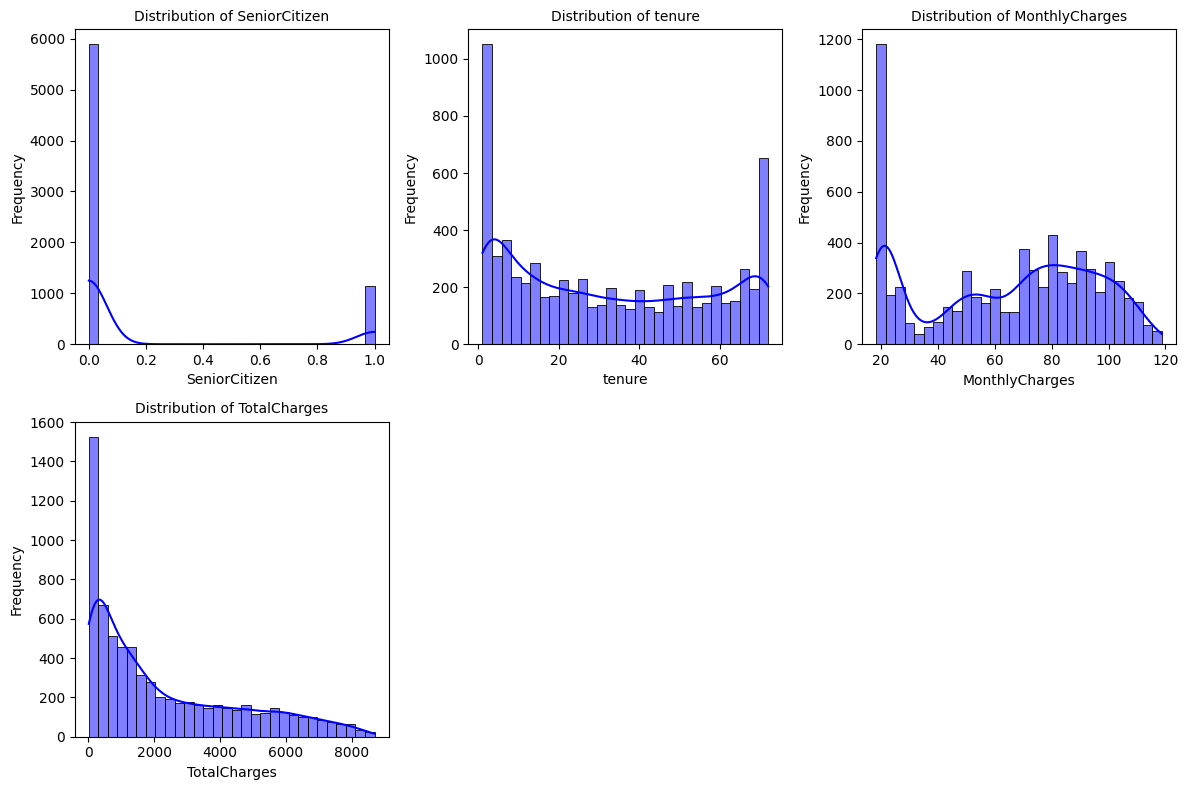

In [80]:
plot_dist(data)

In [81]:
def plot_bars(data, max_unique = 30):
  categorical_cols = [
      col for col in data.select_dtypes(include=['object', 'category']).columns
      if data[col].nunique() < max_unique
  ]
  num_cols = len(categorical_cols)

  if num_cols == 0:
    return

  num_rows = math.ceil(num_cols / 3)
  num_cols = min(num_cols, 3)

  fig, axes = plt.subplots(num_rows, num_cols, figsize = (12, 4 * num_rows))
  axes = axes.flatten()

  for i, col in enumerate(categorical_cols):
    data[col].value_counts().plot.bar(
        ax = axes[i],
        color = 'blue',
        edgecolor = 'black'
    )
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Categories')

  for j in range(i +1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


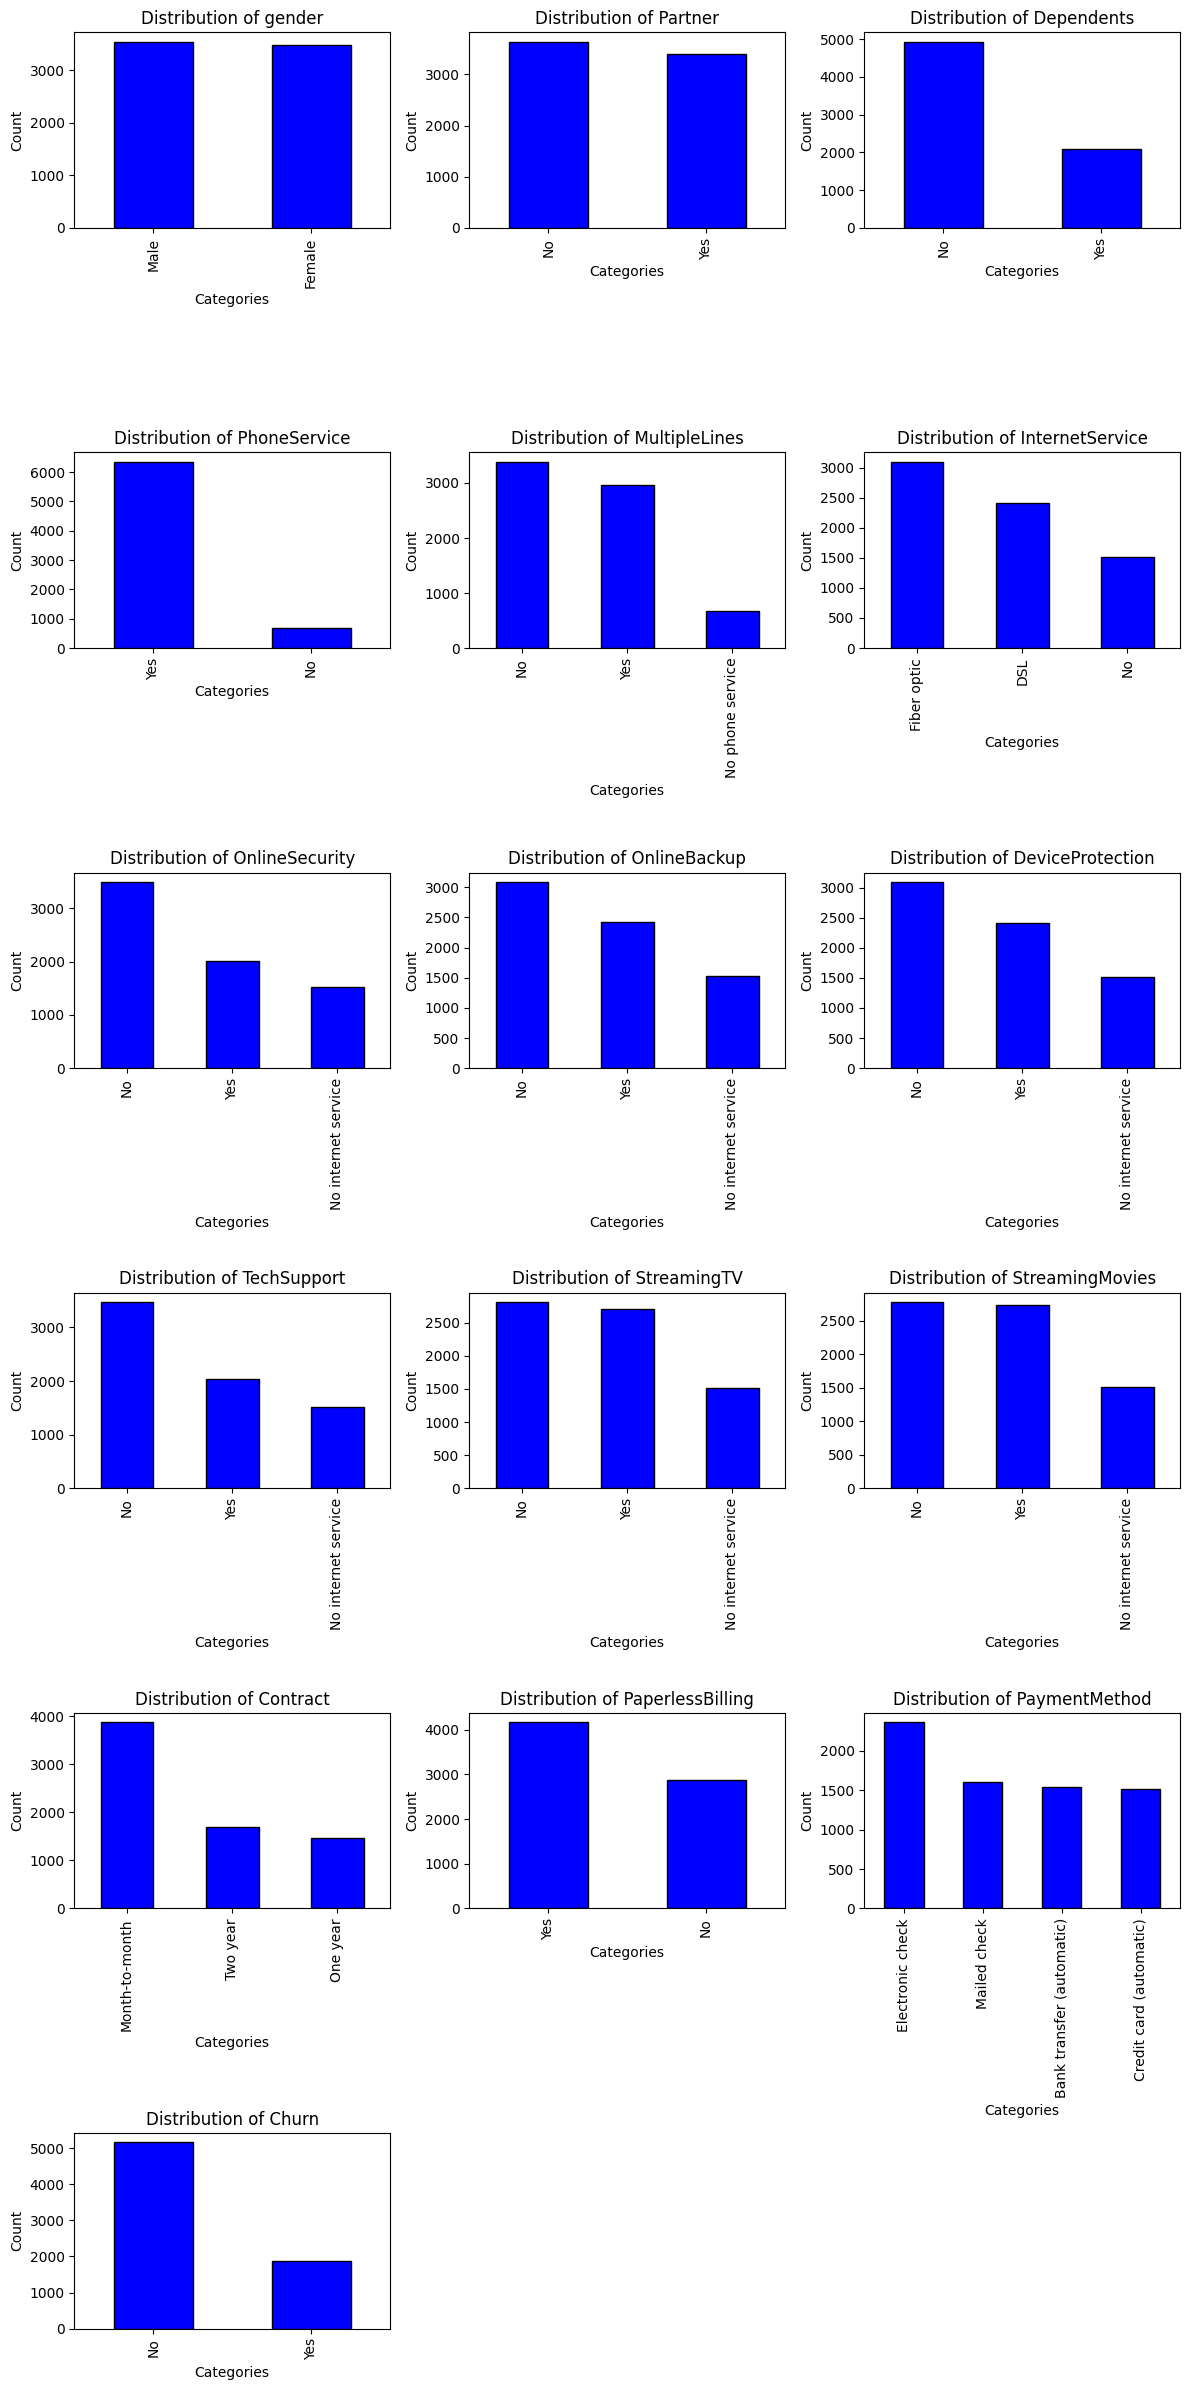

In [82]:
plot_bars(data)

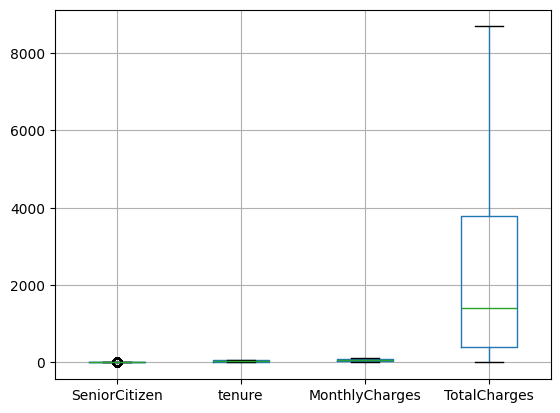

In [83]:
data.boxplot()
plt.show()

<ipython-input-84-d25dfd6aea41>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'Churn', data = data, palette = 'Set2')


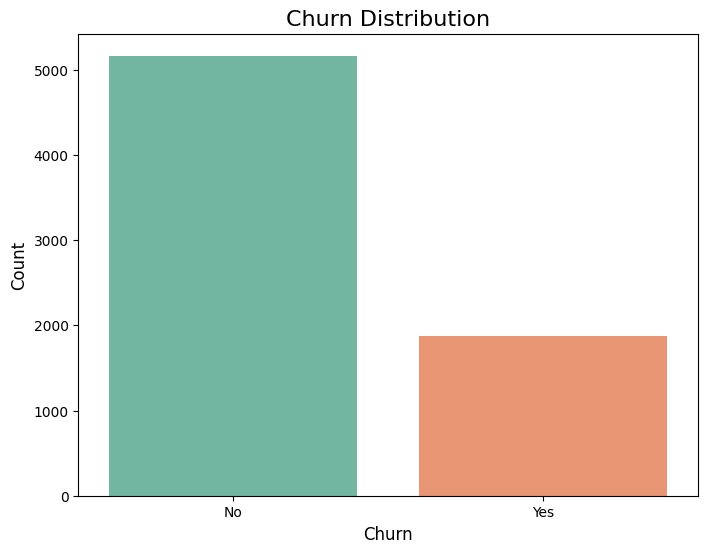

In [84]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Churn', data = data, palette = 'Set2')

plt.title('Churn Distribution', fontsize = 16)
plt.xlabel('Churn', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

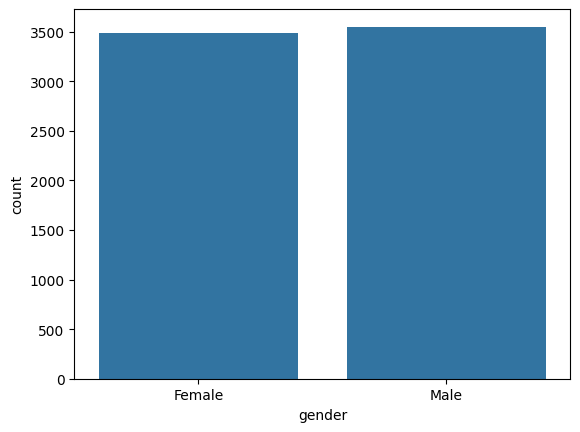

In [85]:
sns.countplot(x = 'gender', data = data)
plt.show()

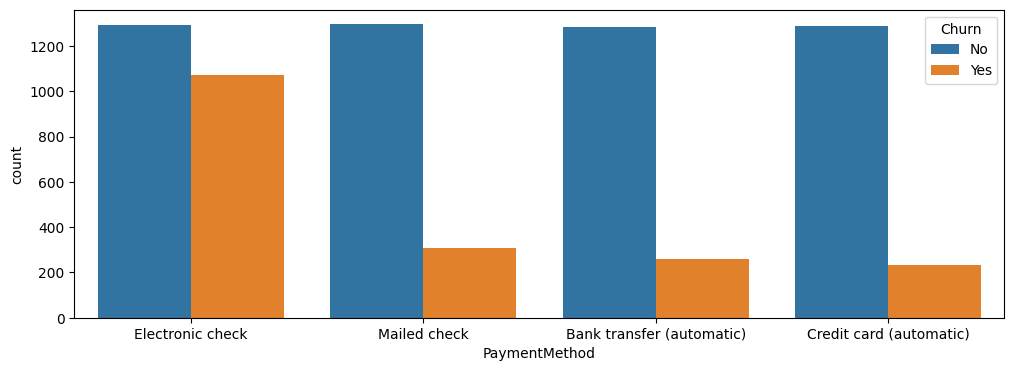

In [86]:
plt.figure(figsize = (12, 4))
sns.countplot(x = 'PaymentMethod', hue = 'Churn', data = data)
plt.show()

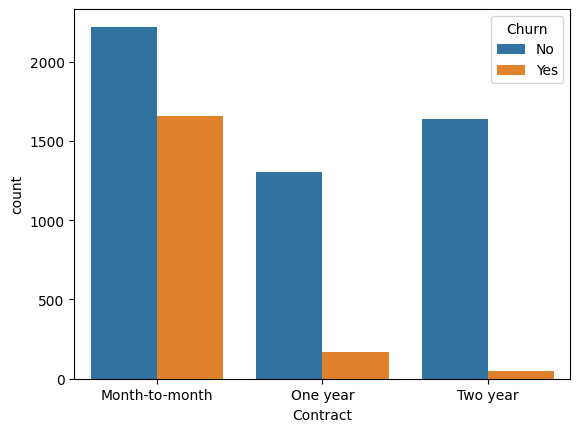

In [87]:
sns.countplot(x = 'Contract', hue = 'Churn', data = data)
plt.show()

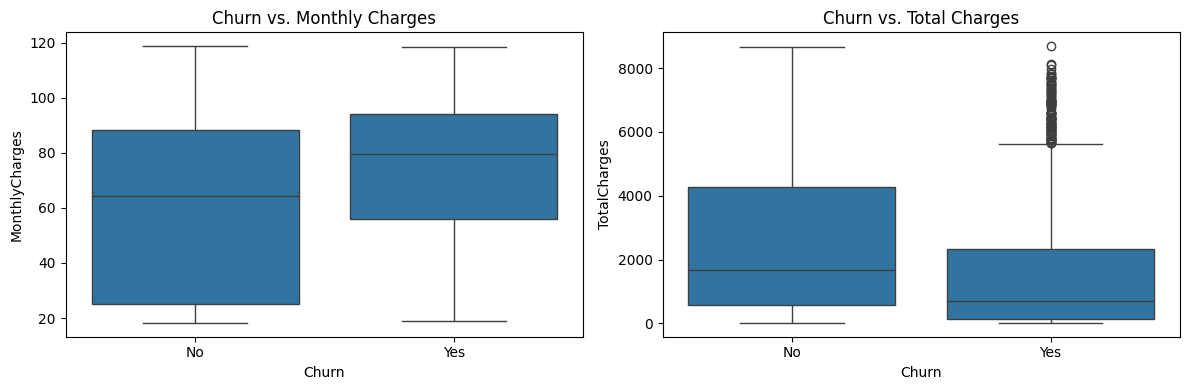

In [88]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = data, ax = axes[0])
sns.boxplot(x = 'Churn', y = 'TotalCharges', data = data, ax = axes[1])

axes[0].set_title('Churn vs. Monthly Charges')
axes[1].set_title('Churn vs. Total Charges')

plt.tight_layout()
plt.show()

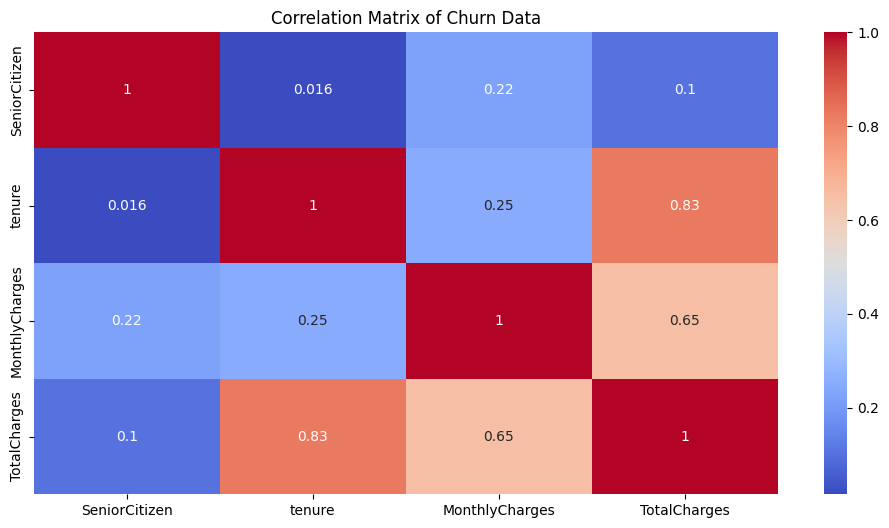

In [89]:
plt.figure(figsize = (12, 6))
sns.heatmap(data.select_dtypes(include = ['number']).corr(), annot = True, cmap = 'coolwarm')
plt.title("Correlation Matrix of Churn Data")
plt.show()

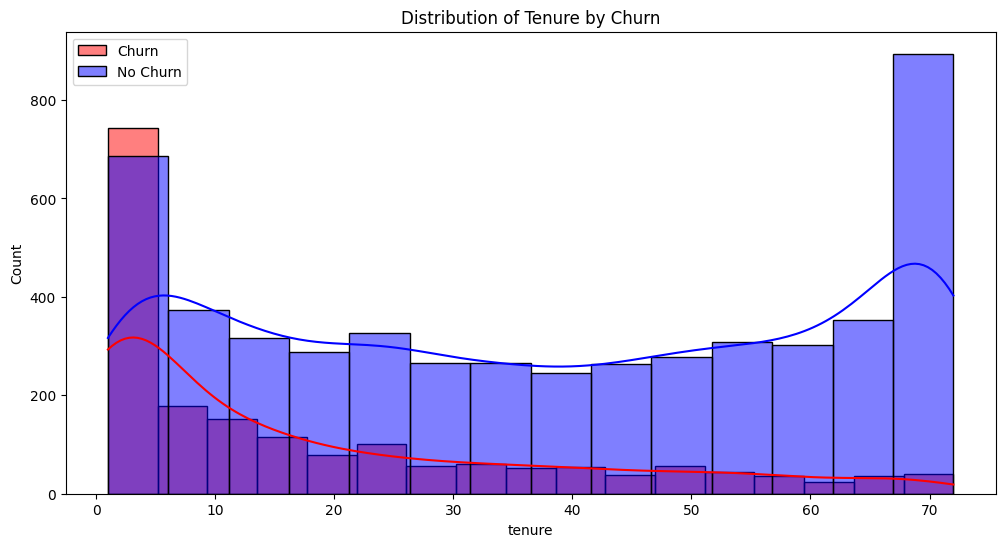

In [90]:
plt.figure(figsize = (12, 6))

sns.histplot(data[data['Churn'] == 'Yes']['tenure'], color = 'red', label = 'Churn', kde = True)
sns.histplot(data[data['Churn'] == 'No']['tenure'], color = 'blue', label = 'No Churn', kde = True)

plt.title('Distribution of Tenure by Churn')
plt.legend()

plt.show()

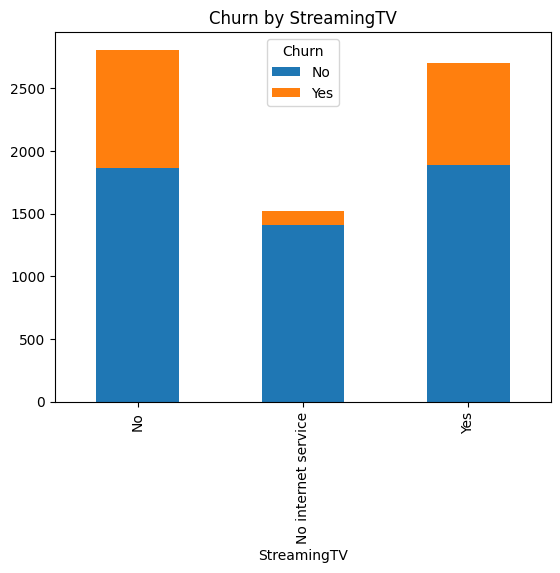

In [91]:
pd.crosstab(data['StreamingTV'], data['Churn']).plot(kind = 'bar', stacked = True)
plt.title('Churn by StreamingTV')
plt.show()

In [92]:
# Now we begin some preprocessing for our model.

In [93]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [94]:
data.Churn = data.Churn.map({'Yes': 1, 'No': 0})

In [95]:
X = data.drop('Churn', axis = 1)
Y = data.Churn

In [96]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state = 90)

In [97]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [101]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
ordinal_cols = ['Contract', 'InternetService']
nominal_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']


ordinal_mapping = [['Month-to-month', 'One year', 'Two year'],
                   ['No', 'DSL', 'Fiber optic']]

binary_transformer = OneHotEncoder(drop='if_binary')
ordinal_transformer = OrdinalEncoder(categories=ordinal_mapping)
nominal_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()


preprocessor = ColumnTransformer([
    ('binary', binary_transformer, binary_cols),
    ('ordinal', ordinal_transformer, ordinal_cols),
    ('nominal', nominal_transformer, nominal_cols),
    ('numeric', numeric_transformer, numeric_cols),
], remainder='passthrough')

In [102]:
X_train_tran = preprocessor.fit_transform(X_train)
X_test_tran = preprocessor.fit_transform(X_test)

In [103]:
def eval_metrics(model, X_train, Y_train, X_test, Y_test):
    Y_train_pred = model.predict(X_train)
    Y_pred = model.predict(X_test)
    print("Test_Metrics")
    print(confusion_matrix(Y_test, Y_pred))
    print(classification_report(Y_test, Y_pred))
    print("Train_Metrics")
    print(confusion_matrix(Y_train, Y_train_pred))
    print(classification_report(Y_train, Y_train_pred))

In [104]:
log_model = LogisticRegression(class_weight = 'balanced', random_state = 90)
log_model.fit(X_train_tran, Y_train)

LogisticRegression(class_weight='balanced', random_state=90)

In [105]:
eval_metrics(log_model, X_train_tran, Y_train, X_test_tran, Y_test)

Test_Metrics
[[718 315]
 [ 75 299]]
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407

Train_Metrics
[[3024 1106]
 [ 282 1213]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      4130
           1       0.52      0.81      0.64      1495

    accuracy                           0.75      5625
   macro avg       0.72      0.77      0.72      5625
weighted avg       0.81      0.75      0.77      5625

